<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.__version__

'1.5.0+cu101'

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [0]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xvzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [0]:
class Conv2DBlock(nn.Module):
  """ Combine Conv2d-BN-LReLU into a single block """
  # the 0.2 negative slope is given in the supplementary materials
  def __init__(self, in_channels, out_channels, kernel_size, activation, conv_kwargs={}, bn_kwargs={}):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **conv_kwargs)
    self.bn = nn.BatchNorm2d(out_channels, **bn_kwargs)
    self.activ = activation

  def forward(self, x):
    return self.activ(self.bn(self.conv(x)))

class SGNet(nn.Module):
  def __init__(self, output_channels=3, kernel_count=32, final_activation=nn.Tanh(), final_bn=False, num_blocks=5):
    super().__init__()
    self.layers = nn.ModuleList()
    self.layers.append(nn.ZeroPad2d(num_blocks)) # initial padding, as explained in the SM
    in_channels = 3
    for _ in range(num_blocks-1): # multiple Conv2D blocks with LeakyReLU
      self.layers.append(Conv2DBlock(in_channels, kernel_count, 3, nn.LeakyReLU(negative_slope=0.2)))
      in_channels = kernel_count
    # the final activation depends on whether this is the generator or critic
    if final_bn:
      self.layers.append(Conv2DBlock(kernel_count, output_channels, 3, final_activation))
    else:
      self.layers.append(nn.Conv2d(kernel_count, output_channels, 3))
      self.layers.append(final_activation)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

class Mean(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.mean(x)

# [gen1] -> View, crit1 = View + crit1
# [gen1, gen2] -> View, crit2 = View + crit2
# ...

def sample_noise_like(ref_img, mean=0.0, stdev=1.0, device='cpu'):
  return torch.from_numpy(np.random.normal(loc=mean, scale=stdev, size=ref_img.shape)).type(ref_img.dtype).to(device)

class MultiScaleSGNetView(nn.Module):
  def __init__(self, scales, scale_sizes, noise_sampler):
    super().__init__()
    # scales = ModuleList[gen1, gen2 ...]
    self.scales = scales
    self.noise_sampler = noise_sampler
    self.scale_sizes = scale_sizes # e.g. [(30, 40), (60, 80), (120, 160)]
    for g in self.scales[:-1]:
      g.requires_grad_(False)
      g.eval()

  def forward(self, x, z_input=None):
    """
    z_input: either None (noise is generated automatically), 
             a single tensor (used as input to the coarsest scale)
             or a list of tensors (used as input to each scale in asc. order)
    """
    for i, g, in enumerate(self.scales):
      if z_input is None:
        z = self.noise_sampler(x)
      elif type(z_input) is list:
        z = z_input[i]
      else:
        z, z_input = z_input, None
      g_input = x + z # add the noise and input image
      x_gen = g(g_input) + x # add the gen. output and the input image
      if i < len(self.scales) - 1:
        x = F.interpolate(x_gen, size=self.scale_sizes[i+1], mode='bicubic')
    return x_gen

def get_weights_and_biases(model):
  return [t for k, t in model.state_dict().items() if 'weight' in k or 'bias' in k]
  

Dataset already downloaded


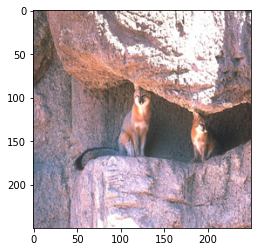

In [4]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize((250, 250), Image.BICUBIC))
plt.imshow(orig_img_uint)

In [0]:
# as given in the paper
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1
NUM_SCALES = 8
SCALING_FACTOR = 4/3
INITIAL_KERNEL_COUNT = 32
INCREASE_KERNEL_COUNT_EVERY = 4 # SCALES
NOISE_BASE_STD = 0.1

PRINT_EVERY = 50
DEVICE = 'cuda'
SEED = 796

In [6]:

def img2net(img_uint):
  # convert [0, 255] uint8 (H, W, C) to [-1, 1] float32 (1, C, H, W)
  rescaled = (img_uint.astype('float32') / 127.5) - 1.0
  chw = np.transpose(rescaled, (2, 0, 1))
  return torch.from_numpy(np.expand_dims(chw, axis=0)).to(DEVICE)

def net2img(img_float):
  chw = np.squeeze(img_float.detach().cpu().numpy())
  hwc = np.transpose(chw, (1, 2, 0))
  return ((hwc + 1.0) * 127.5).astype('uint8')

def create_scale_pyramid(img, scaling_factor, num_scales):
  """ img: a 4D torch tensor """
  scaled_images = []
  scale_sizes = []
  shape = tuple(img.shape)[2:] # (N, C, H, W) -> (H, W)
  for i in range(num_scales):
    scale_sizes.append(shape)
    scaled_images.append(img)
    shape = tuple((np.array(shape, dtype='float64') * scaling_factor).astype('int64'))
    img = F.interpolate(img, size=shape, mode='bicubic')
  return scaled_images, scale_sizes

# seed stuff
np.random.seed(SEED)
torch.manual_seed(SEED)

# create the sizes
original_img = img2net(orig_img_uint)
original_img_scales, scale_sizes = create_scale_pyramid(original_img, 1/SCALING_FACTOR, NUM_SCALES)
original_img_scales, scale_sizes = original_img_scales[::-1], scale_sizes[::-1] # reverse since we start from coarsest

# create the constant noise used in reconstruction along with the MSE loss func.
z_rec_coarsest = sample_noise_like(original_img_scales[0], stdev=NOISE_BASE_STD, device=DEVICE)
z_rec = [z_rec_coarsest]

# constant zero input for the coarsest scale
generator_zero_input = torch.zeros_like(z_rec_coarsest)

kernel_count = INITIAL_KERNEL_COUNT
generator = None
generators = nn.ModuleList()
gen_losses, crit_losses = [], []
rmse = 1 # initial noise multiplier
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))

  # get the original image at the necessary scale for reconstruction
  orig_img = original_img_scales[scale_index]

  if generator is not None:
    reconstruction = generator(generator_zero_input, z_rec)  
    # calculate the RMSE to use for scaling the input in the next step
    scaled_reconstruction = F.interpolate(reconstruction, size=scale_sizes[scale_index], mode='bicubic')
    rmse = F.mse_loss(scaled_reconstruction, orig_img).item()

  # create the noise sampler based on the RMSE
  noise_sampler = lambda x: sample_noise_like(x, mean=0.0, stdev=rmse * NOISE_BASE_STD, device=DEVICE)
  print('RMSE: {:.2f}'.format(rmse))

  ## initialize the generator
  # increase kernel count if necessary
  kernel_count_changed = False
  if scale_index != 0 and scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    kernel_count *= 2
    kernel_count_changed = True
  # create a generator for this specific scale
  scale_generator = SGNet(output_channels=3, kernel_count=kernel_count, final_activation=nn.Tanh()).to(DEVICE)
  # if possible, initialize with weights from the lower layer
  if scale_index != 0 and not kernel_count_changed:
    prev_generator = generators[-1]
    prev_gen_weights = prev_generator.state_dict()
    scale_generator.load_state_dict(prev_gen_weights)
  # set train mode & add to generator list
  scale_generator.train()
  generators.append(scale_generator)
  # create a single generator view
  generator = MultiScaleSGNetView(generators, scale_sizes, noise_sampler)

  ## initialize the critic (discriminator)
  # the authors recommend initializing the discriminator using the weights of
  #  the previous one, which means that we do not need to actually re-create 
  # the number of kernels is being changed the discriminator unless
  if scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    scale_patch_critic = SGNet(output_channels=1, kernel_count=kernel_count, final_activation=nn.Identity()).to(DEVICE)
    critic = torch.nn.Sequential(scale_patch_critic, Mean()).to(DEVICE)

  # weight of gen0 to ensure it is not trained
  print('Norm sums:')
  for i, gen in enumerate(generators):
    wbs = get_weights_and_biases(gen)
    norm = torch.tensor([torch.norm(x) for x in wbs]).sum().item()
    print('Gen-{} norm: {:.2f}'.format(i, norm))
  print('Critic norm: {:.2f}'.format(torch.tensor([torch.norm(x) for x in get_weights_and_biases(critic)]).sum().item()))

  # re-create the optimizers and schedulers
  gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  gen_sched = torch.optim.lr_scheduler.StepLR(gen_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  dis_sched = torch.optim.lr_scheduler.StepLR(dis_optimizer, LR_DROP_STEP, LR_DROP_MULT)
    
  if scale_index != 0:
    z_rec.append(torch.zeros_like(orig_img))
  print(orig_img.shape)

  for step in range(NUM_ITERS):

    # real 1, fake 0

    for _ in range(DIS_STEP_PER_ITER):
      dis_optimizer.zero_grad()

      fake_imgc = generator(generator_zero_input)
      epsilon = np.random.uniform(0, 1)

      # adversarial loss
      # take a sample from the line between the real and generated images
      # for use in the gradient penalty (Impr. Training of WGANs)
      grad_sample = epsilon * orig_img + (1 - epsilon) * fake_imgc
      f_grad_sample = critic(grad_sample)
      grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)
      grad_loss = (torch.norm(grad) - 1)**2

      fake_loss = critic(fake_imgc)
      real_loss = -critic(orig_img)
      dis_loss =  fake_loss + real_loss + GP_WEIGHT * grad_loss
      dis_loss.backward()
      dis_optimizer.step()
      dis_sched.step()
      crit_losses.append(dis_loss.item())
    
    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      # always provide zero input to the coarsest scale
      # the model handles noise sampling on its own
      fake_img = generator(generator_zero_input)

      # adversarial loss
      adv_loss = -critic(fake_img)

      # reconstruction loss
      rec_img = generator(generator_zero_input, z_rec)
      # the representation space of the images is not clear in the paper.
      # since the reconstruction loss seemed very low to us in the [-1, 1]
      # range, we decided to calculate it in the [0, 255] range instead
      # EDIT: after checking out their own code, it seems that there is
      # no multiplier. however, the reconstruction loss remains too small?
      rec_loss = F.mse_loss(orig_img, rec_img)

      gen_loss = adv_loss + REC_ALPHA * rec_loss
      gen_loss.backward()
      gen_optimizer.step()
      gen_sched.step()
      gen_losses.append(gen_loss.item())

    if step % PRINT_EVERY == 0:
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.data, rec_loss.data))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.data, real_loss.data, grad_loss.data))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
      plt.imshow(net2img(fake_img))
      plt.show()
      last_print = time()

  print('Reconstruction:')
  plt.imshow(net2img(generator(generator_zero_input, z_rec)))
  plt.show()


KeyboardInterrupt: ignored

In [0]:
plt.plot(crit_losses)
plt.show()

In [0]:
!nvidia-smi

In [14]:
print(scale_patch_critic(torch.ones(1, 3, 5, 5).cuda()))

tensor([[[[ 2012.2988,  2605.2092,  2767.8027,  2340.7258,  1542.9116],
          [ -425.1706,  -706.6548,  -848.1088, -1016.8680, -1072.0400],
          [ -388.1819,  -881.5381, -1158.3008, -1353.7656, -1296.8536],
          [ -612.4533, -1282.3414, -1639.7859, -1768.6969, -1484.5004],
          [ -331.3811,  -822.8889, -1009.0806, -1105.8821,  -911.6993]]]],
       device='cuda:0', grad_fn=<AddBackward0>)
